In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install evaluate seqeval

  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.12.0 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9",

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Loading and preparing train data...
Loading and preparing dev data...
Loading and preparing test data...


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-376241557.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Starting model training...


Epoch,Training Loss,Validation Loss,Emoji Camo,Emoji Char Camo,Inv Camo,Leetspeak,Mix Camo,Punct Camo,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,F1
1,0.017500,0.038994,"{'precision': 0.9994882292732856, 'recall': 1.0, 'f1': 0.9997440491425647, 'number': 1953}","{'precision': 0.9986057859881492, 'recall': 0.9845360824742269, 'f1': 0.991521024398685, 'number': 2910}","{'precision': 0.9905660377358491, 'recall': 1.0, 'f1': 0.9952606635071091, 'number': 315}","{'precision': 0.9850689127105666, 'recall': 0.9996114996114996, 'f1': 0.9922869263401466, 'number': 2574}","{'precision': 0.9965344628417405, 'recall': 0.8493600262553331, 'f1': 0.9170800850460666, 'number': 3047}","{'precision': 0.8684059633027523, 'recall': 0.9983520105471325, 'f1': 0.9288561790861699, 'number': 3034}",0.962784,0.963132,0.962958,0.988313,0.962958



--- Final Detailed Evaluation ---

Combining dev and test datasets for final evaluation...
Combined set has 29517 examples.

Running final prediction on combined test set...


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)



--- Final Test Set Classification Report ---
Entity                Precision     Recall   F1-Score    Support
-----------------------------------------------------------------
EMOJI_CAMO               0.9993     1.0000     0.0000       4113
EMOJI_CHAR_CAMO          0.9984     0.9858     0.0000       6189
INV_CAMO                 0.9927     1.0000     0.0000        680
LEETSPEAK                0.9854     0.9991     0.0000       5457
MIX_CAMO                 0.9971     0.8467     0.0000       6476
PUNCT_CAMO               0.8666     0.9991     0.0000       6454
-----------------------------------------------------------------
Accuracy                                        0.9883
Overall (Micro Avg)      0.9623     0.9628     0.9626

Confusion matrix saved to: /content/drive/My Drive/Vidath/transformer_model_plots/final_confusion_matrix.png


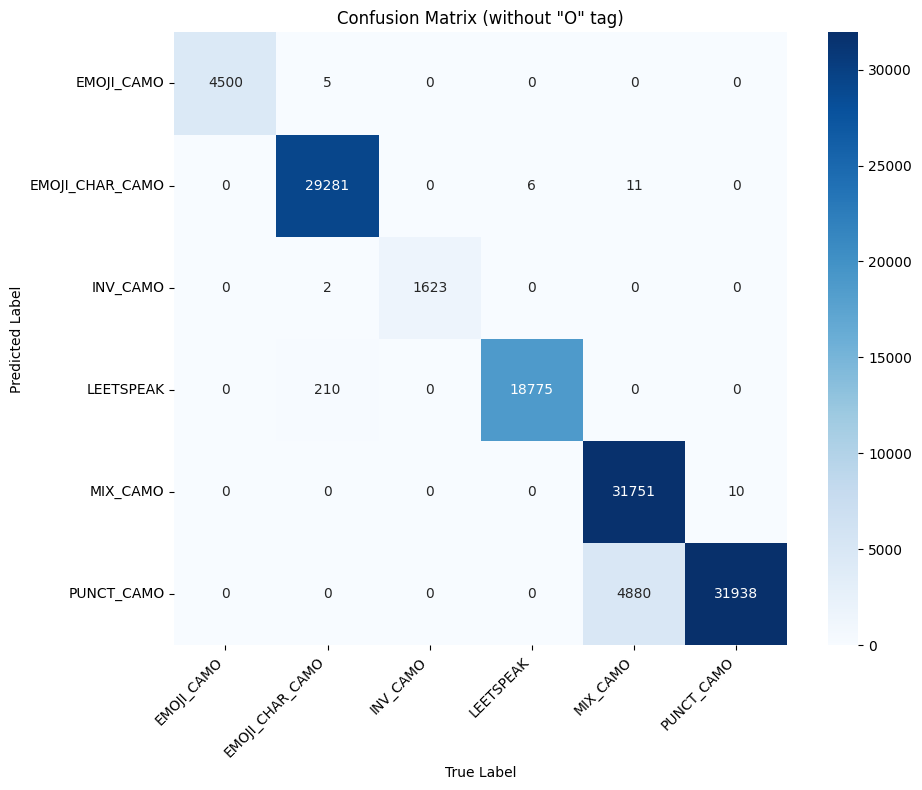

Metrics bar chart saved to: /content/drive/My Drive/Vidath/transformer_model_plots/final_metrics_barchart.png


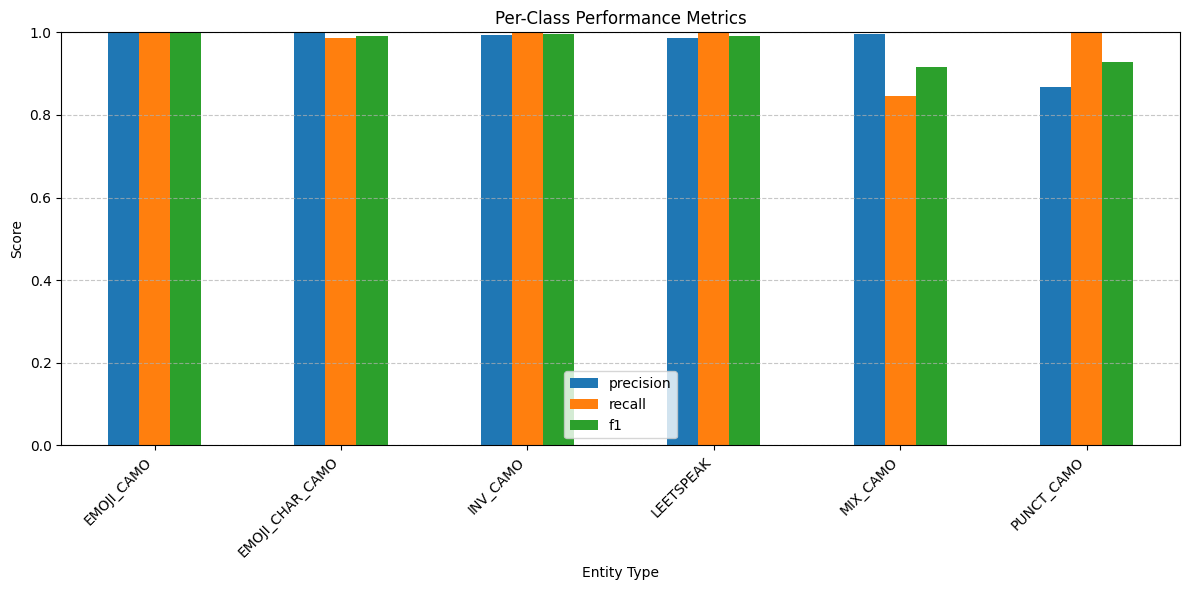


Model saved to /content/drive/My Drive/Vidath/xlm-roberta-large-ner-model-emoji


In [ ]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
from datasets import Dataset, concatenate_datasets
from evaluate import load
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
import torch
import re
import os

# --- Imports for visualization ---
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Need seqeval for metric computation
try:
    from evaluate import load
    load("seqeval")
except ImportError:
    print("Installing seqeval and evaluate...")
    import subprocess
    subprocess.check_call(["pip", "install", "evaluate", "seqeval"])
    from evaluate import load

# --- Labels and Data Loading (No changes here) ---
BASE_LABELS = ["LEETSPEAK", "PUNCT_CAMO", "INV_CAMO", "MIX_CAMO", "EMOJI_CAMO", "EMOJI_CHAR_CAMO"]
LABEL_LIST = ["O"] + [f"B-{label}" for label in BASE_LABELS] + [f"I-{label}" for label in BASE_LABELS]
label_to_id = {l: i for i, l in enumerate(LABEL_LIST)}
id_to_label = {i: l for l, i in label_to_id.items()}
MODEL_CHECKPOINT = "xlm-roberta-large"

def load_and_prepare_data(file_path, tokenizer, label_to_id):
    df = pd.read_csv(file_path, encoding='utf-8')
    grouped = df.groupby('Text').apply(lambda x: x.to_dict('records'), include_groups=False).reset_index(name='entities')
    data_for_hf = []
    for _, row in grouped.iterrows():
        text = str(row['Text']) if pd.notna(row['Text']) else ""
        entities = row['entities']
        tokenized_inputs = tokenizer(text, truncation=True, max_length=128)
        labels = [-100] * len(tokenized_inputs.input_ids)
        word_ids = tokenized_inputs.word_ids()
        for i, word_id in enumerate(word_ids):
            if word_id is not None:
                labels[i] = label_to_id['O']
        for entity in entities:
            start_char, end_char, label = entity['Start'], entity['End'], entity['Label']
            token_start, token_end = tokenized_inputs.char_to_token(start_char), tokenized_inputs.char_to_token(end_char - 1)
            if token_start is not None and token_end is not None and f"B-{label}" in label_to_id:
                b_label_id, i_label_id = label_to_id[f"B-{label}"], label_to_id[f"I-{label}"]
                labels[token_start] = b_label_id
                for i in range(token_start + 1, token_end + 1):
                    if i < len(labels): labels[i] = i_label_id
        tokenized_inputs["labels"] = labels
        data_for_hf.append(tokenized_inputs)
    return Dataset.from_list(data_for_hf)

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT, use_fast=True)
print("Loading and preparing train data...")
train_dataset = load_and_prepare_data("/content/drive/My Drive/Vidath/Dataset/augmented_train_all_combo_emoji.csv", tokenizer, label_to_id)
print("Loading and preparing dev data...")
dev_dataset = load_and_prepare_data("/content/drive/My Drive/Vidath/Dataset/augmented_dev_all_combo_emoji.csv", tokenizer, label_to_id)
print("Loading and preparing test data...")
test_dataset = load_and_prepare_data("/content/drive/My Drive/Vidath/Dataset/augmented_test_all_combo_emoji.csv", tokenizer, label_to_id)

# --- Model Loading and Training Arguments (No changes here) ---
model = AutoModelForTokenClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=len(LABEL_LIST), id2label=id_to_label, label2id=label_to_id)
training_args = TrainingArguments(
    output_dir="./results_emoji", eval_strategy="epoch", learning_rate=2e-5,
    per_device_train_batch_size=8, per_device_eval_batch_size=8, num_train_epochs=1,
    weight_decay=0.01, logging_dir="./logs_emoji", logging_steps=10,
    save_strategy="epoch", load_best_model_at_end=True, metric_for_best_model="f1",
    push_to_hub=False, report_to="none",
)

# ----------------------------------------------------------------------------------
# --- MODIFICATION 1: Update compute_metrics to return the full results dictionary ---
# ----------------------------------------------------------------------------------
metric = load("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id_to_label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    # This now returns the full dictionary with per-class scores
    results = metric.compute(predictions=true_predictions, references=true_labels)
    # The Trainer needs this top-level 'f1' key for 'load_best_model_at_end'
    results['f1'] = results['overall_f1']
    return results

# --- Train the Model (No changes here) ---
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset,
    eval_dataset=dev_dataset, tokenizer=tokenizer,
    data_collator=data_collator, compute_metrics=compute_metrics
)
print("\nStarting model training...")
trainer.train()

# ----------------------------------------------------------------------------
# --- MODIFICATION 2: Add new functions for detailed reporting and plotting ---
# ----------------------------------------------------------------------------
def print_classification_report(report_dict):
    print(f"{'Entity':<20} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    print("-" * 65)
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):
            name, precision = label, metrics.get('precision', 0)
            recall, f1 = metrics.get('recall', 0), metrics.get('f1-score', 0)
            support = metrics.get('number', 0)
            print(f"{name:<20} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f} {support:>10}")
    print("-" * 65)
    precision, recall = report_dict.get('overall_precision', 0), report_dict.get('overall_recall', 0)
    f1, accuracy = report_dict.get('overall_f1', 0), report_dict.get('overall_accuracy', 0)
    print(f"{'Accuracy':<20} {accuracy:>33.4f}")
    print(f"{'Overall (Micro Avg)':<20} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f}\n")

def aggregate_bio_tags(labels):
    return [label[2:] if label != 'O' else 'O' for label in labels]

def plot_confusion_matrix(predictions, true_labels, id_to_label, base_labels, save_path):
    pred_ids = np.argmax(predictions, axis=2)
    true_labels_list = [[id_to_label.get(l, "O") for l in sent if l != -100] for sent in true_labels]
    pred_labels_list = [[id_to_label.get(p, "O") for p, l in zip(pred_sent, label_sent) if l != -100]
                        for pred_sent, label_sent in zip(pred_ids, true_labels)]
    true_flat, pred_flat = [item for sublist in true_labels_list for item in sublist], [item for sublist in pred_labels_list for item in sublist]
    true_agg, pred_agg = aggregate_bio_tags(true_flat), aggregate_bio_tags(pred_flat)
    labels_without_o = sorted([l for l in base_labels if l != 'O'])
    mat = confusion_matrix(true_agg, pred_agg, labels=labels_without_o)
    plt.figure(figsize=(10, 8))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
                xticklabels=labels_without_o, yticklabels=labels_without_o, cmap="Blues")
    plt.title('Confusion Matrix (without "O" tag)'); plt.xlabel('True Label'); plt.ylabel('Predicted Label')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Confusion matrix saved to: {save_path}")
    plt.show()

def plot_metrics_barchart(report_dict, save_path):
    class_data = {label: metrics for label, metrics in report_dict.items() if isinstance(metrics, dict)}
    df = pd.DataFrame(class_data).T.reset_index().rename(columns={'index': 'Entity', 'f1-score': 'f1'})
    df.plot(x='Entity', y=['precision', 'recall', 'f1'], kind='bar', figsize=(12, 6))
    plt.title('Per-Class Performance Metrics'); plt.ylabel('Score'); plt.xlabel('Entity Type')
    plt.xticks(rotation=45, ha='right'); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Metrics bar chart saved to: {save_path}")
    plt.show()

# -------------------------------------------------------------------
# --- MODIFICATION 3: New Final Evaluation Block ---
# -------------------------------------------------------------------
print("\n--- Final Detailed Evaluation ---")

# Combine dev and test sets for a final, comprehensive evaluation
print("\nCombining dev and test datasets for final evaluation...")
combined_test_dataset = concatenate_datasets([dev_dataset, test_dataset])
print(f"Combined set has {len(combined_test_dataset)} examples.")

# Use trainer.predict to get metrics AND raw predictions
print("\nRunning final prediction on combined test set...")
test_results = trainer.predict(combined_test_dataset)

# The metrics are already computed because we passed `compute_metrics` to the Trainer
final_metrics = test_results.metrics

# Extract raw predictions and labels for the confusion matrix
raw_predictions = test_results.predictions
true_label_ids = test_results.label_ids

# Create directory for plots
plots_dir = "/content/drive/My Drive/Vidath/transformer_model_plots"
os.makedirs(plots_dir, exist_ok=True)

# 1. Print the detailed classification report
print("\n--- Final Test Set Classification Report ---")
# The key is 'test_...' because predict defaults to the 'test' prefix
report_data = {k.replace('test_', ''): v for k, v in final_metrics.items()}
print_classification_report(report_data)

# 2. Generate, save, and display the plots
cm_save_path = os.path.join(plots_dir, "final_confusion_matrix.png")
plot_confusion_matrix(raw_predictions, true_label_ids, id_to_label, BASE_LABELS, cm_save_path)

metrics_save_path = os.path.join(plots_dir, "final_metrics_barchart.png")
plot_metrics_barchart(report_data, metrics_save_path)

# 8. Save Model and Example Prediction (no changes needed)
model_save_path = "/content/drive/My Drive/Vidath/xlm-roberta-large-ner-model-emoji"
trainer.save_model(model_save_path)
print(f"\nModel saved to {model_save_path}")

def predict_ner(text, model, tokenizer, id_to_label):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, return_offsets_mapping=True)
    offset_mapping = inputs.pop("offset_mapping")[0]
    device = model.device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_ids = torch.argmax(logits, axis=2).squeeze().tolist()
    entities, current_entity = [], None
    for i, pred_id in enumerate(predicted_ids):
        label, (char_start, char_end) = id_to_label[pred_id], offset_mapping[i]
        if char_start == char_end: continue
        if label.startswith("B-"):
            if current_entity: entities.append(current_entity)
            current_entity = {"entity": text[char_start:char_end], "label": label[2:], "start": char_start, "end": char_end}
        elif label.startswith("I-") and current_entity and label[2:] == current_entity["label"]:
            current_entity["end"] = char_end
            current_entity["entity"] = text[current_entity["start"]:current_entity["end"]]
        else:
            if current_entity: entities.append(current_entity)
            current_entity = None
    if current_entity: entities.append(current_entity)
    return entities
